# App Reconhecimento Facial

Neste projeto seguimos o tutorial de **Nicholas Renotte** para construção de app de reconhecimento facial utilizando redes siamesas.

O tutorial pode ver visto aqui: https://www.youtube.com/watch?v=LKispFFQ5GU Nadescrição do vídeo estão os links do código do notebook e do app.

O App utiliza redes siamesas para fazer o reconhecimento facial
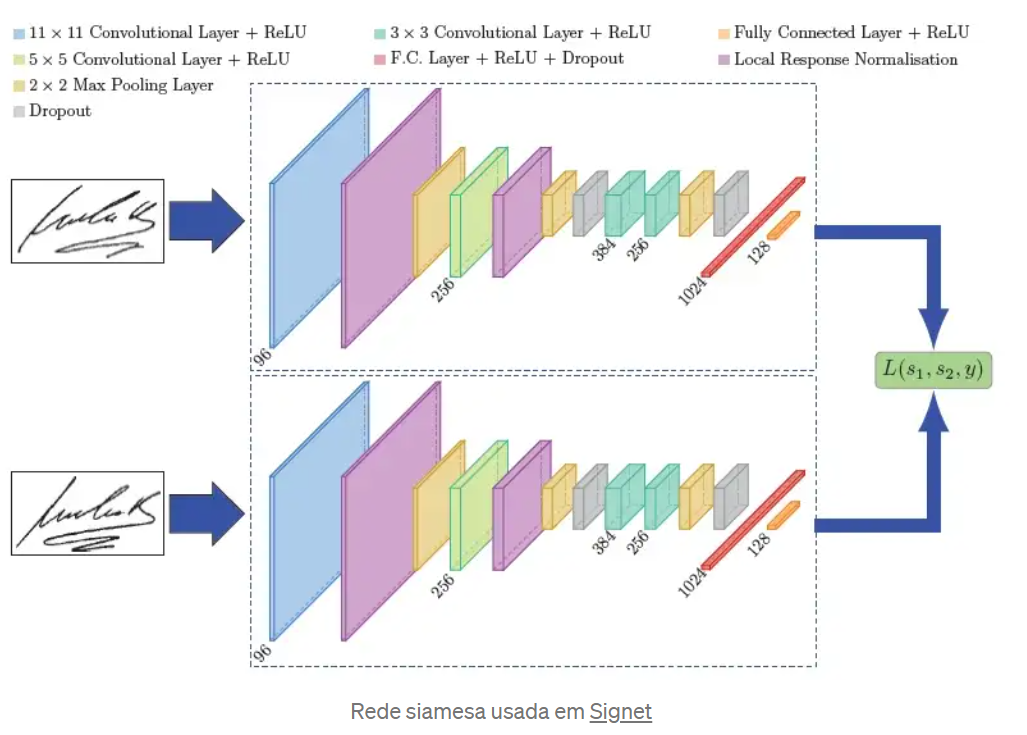

# 1. Setup

## 1.1 Install Dependencies

In [1]:
#!pip install --user tensorflow==2.5.1 tensorflow-gpu==2.5.1 opencv-python matplotlib

In [2]:
#pip install opencv

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [4]:
# Import uuid library to generate unique image names
import uuid

In [5]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\8478eb30-71c3-11ed-ae42-5ccd5b6eb8d7.jpg'

In [6]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

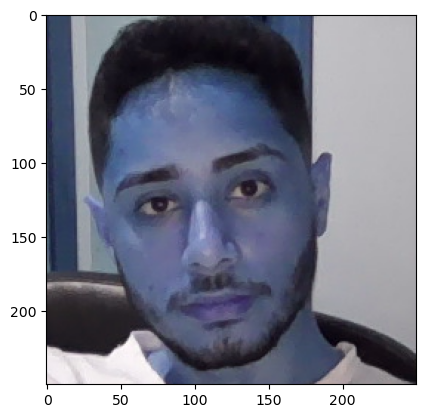

In [7]:
plt.imshow(frame)

# 2.x NEW - Data Augmentation

In [8]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [9]:
import os
import uuid

In [12]:
img_path = os.path.join(ANC_PATH, '8b0fcdd8-71c3-11ed-bf64-5ccd5b6eb8d7.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [12]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data\\anchor\\bdfe1666-6a88-11ed-880f-00090faa0001.jpg'


## 3.2 Preprocessing - Scale and Resize

In [13]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [14]:
img = preprocess('data\\anchor\\94b26913-6a88-11ed-b66f-00090faa0001.jpg')

In [15]:
img.numpy().max() 

0.9377451

In [16]:
positive.map(preprocess)

<MapDataset shapes: (100, 100, None), types: tf.float32>

## 3.3 Create Labelled Dataset

In [20]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
samples = data.as_numpy_iterator()

In [19]:
exampple = samples.next()

In [20]:
exampple

(b'data\\anchor\\beaf3b3e-6acf-11ed-bc57-00090faa0001.jpg',
 b'data\\positive\\05678abb-7175-11ed-adad-00090faa0001.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
res = preprocess_twin(*exampple)

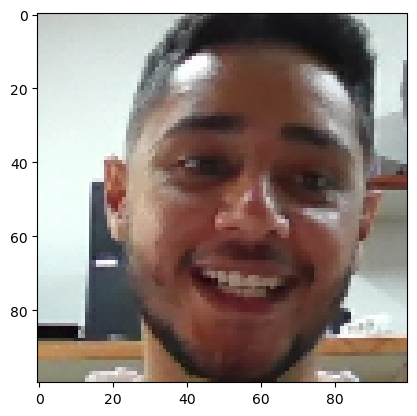

In [23]:
plt.imshow(res[1])

In [24]:
res[2]

1.0

In [25]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [26]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [27]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [28]:
inp = Input(shape=(100,100,3), name='input_image')

In [29]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [30]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [31]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [32]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [33]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [34]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [36]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [37]:
embedding = make_embedding()

In [38]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [39]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [40]:
l1 = L1Dist()

In [41]:
#l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [42]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [43]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [44]:
siamese_layer = L1Dist()

In [45]:
distances = siamese_layer(inp_embedding, val_embedding)

In [46]:
classifier = Dense(1, activation='sigmoid')(distances)

In [47]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [48]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [50]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [51]:
siamese_model = make_siamese_model()

In [52]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [53]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [54]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [56]:
test_batch = train_data.as_numpy_iterator()

In [57]:
batch_1 = test_batch.next()

In [58]:
X = batch_1[:2]

In [59]:
y = batch_1[2]

In [60]:
y

array([0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.],
      dtype=float32)

In [61]:
tf.losses.BinaryCrossentropy??

In [62]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [63]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [64]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [65]:
EPOCHS = 50

In [70]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
10/10 [==============================] - 263s 25s/step
0.35228294 0.085365854 0.875

 Epoch 2/50
10/10 [==============================] - 254s 25s/step
0.39898875 0.81578946 0.95384616

 Epoch 3/50
10/10 [==============================] - 269s 27s/step
0.18945464 0.84 0.9402985

 Epoch 4/50
10/10 [==============================] - 25691s 2852s/step
0.18089105 0.95 0.96202534

 Epoch 5/50
10/10 [==============================] - 237s 24s/step
0.1344118 0.9518072 0.97530866

 Epoch 6/50
10/10 [==============================] - 247s 25s/step
0.038470328 0.974359 0.974359

 Epoch 7/50
10/10 [==============================] - 255s 26s/step
0.091203205 0.97619045 0.9879518

 Epoch 8/50
10/10 [==============================] - 250s 25s/step
0.010188932 0.974359 1.0

 Epoch 9/50
10/10 [==============================] - 346s 34s/s

# 6. Evaluate Model

## 6.1 Import Metrics

In [66]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [67]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [68]:
y_hat = siamese_model.predict([test_input, test_val])

In [69]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]

In [70]:
y_true

array([1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [71]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.8333333

In [72]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.71428573

In [73]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

0.82857144 0.48333332


## 6.4 Viz Results

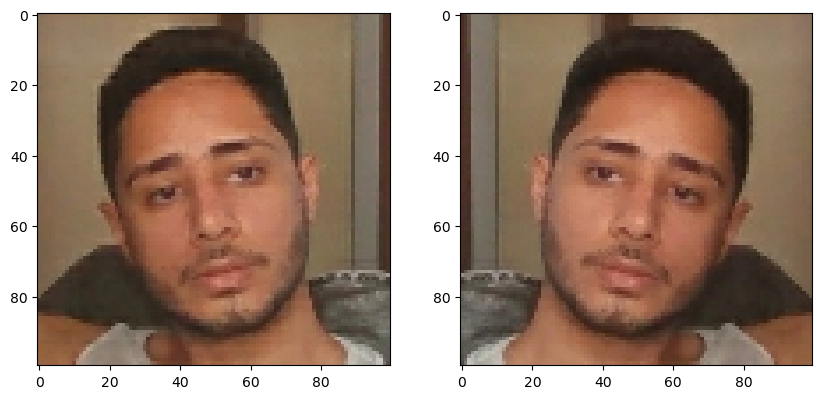

In [74]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [80]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [75]:
L1Dist

__main__.L1Dist

In [76]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [77]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[8.9330870e-01],
       [9.9865770e-01],
       [1.0000000e+00],
       [1.2763891e-07]], dtype=float32)

In [78]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

## 8.1 Verification Function

In [79]:
os.listdir(os.path.join('application_data', 'verification_images'))

['b580c736-6a9c-11ed-90cf-00090faa0001.jpg',
 'b68a4ca0-6a9c-11ed-9319-00090faa0001.jpg',
 'b68aaf64-6a9c-11ed-aacb-00090faa0001.jpg',
 'b68ad683-6a9c-11ed-a5ea-00090faa0001.jpg',
 'b80ed07e-6a9c-11ed-87ae-00090faa0001.jpg',
 'fcf2d47c-6acd-11ed-9c6a-00090faa0001.jpg',
 'fcf3c750-6acd-11ed-bfaa-00090faa0001.jpg',
 'fcf48ed7-6acd-11ed-9d12-00090faa0001.jpg',
 'fcf5b9dd-6acd-11ed-9907-00090faa0001.jpg',
 'fcf6d859-6acd-11ed-9b0f-00090faa0001.jpg',
 'fd7dc824-6acd-11ed-b9fa-00090faa0001.jpg',
 'fe768803-6acd-11ed-88a6-00090faa0001.jpg',
 'fe965125-6acd-11ed-9354-00090faa0001.jpg',
 'fe97327b-6acd-11ed-891a-00090faa0001.jpg',
 'feb48e5b-6acd-11ed-a0fa-00090faa0001.jpg']

In [80]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [81]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\b580c736-6a9c-11ed-90cf-00090faa0001.jpg
application_data\verification_images\b68a4ca0-6a9c-11ed-9319-00090faa0001.jpg
application_data\verification_images\b68aaf64-6a9c-11ed-aacb-00090faa0001.jpg
application_data\verification_images\b68ad683-6a9c-11ed-a5ea-00090faa0001.jpg
application_data\verification_images\b80ed07e-6a9c-11ed-87ae-00090faa0001.jpg
application_data\verification_images\fcf2d47c-6acd-11ed-9c6a-00090faa0001.jpg
application_data\verification_images\fcf3c750-6acd-11ed-bfaa-00090faa0001.jpg
application_data\verification_images\fcf48ed7-6acd-11ed-9d12-00090faa0001.jpg
application_data\verification_images\fcf5b9dd-6acd-11ed-9907-00090faa0001.jpg
application_data\verification_images\fcf6d859-6acd-11ed-9b0f-00090faa0001.jpg
application_data\verification_images\fd7dc824-6acd-11ed-b9fa-00090faa0001.jpg
application_data\verification_images\fe768803-6acd-11ed-88a6-00090faa0001.jpg
application_data\verification_images\fe965125-6acd-11ed-9354-000

In [82]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [96]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
True
False


In [92]:
np.sum(np.squeeze(results) > 0.9)

13

In [93]:
results

[array([[0.9999969]], dtype=float32),
 array([[0.99034965]], dtype=float32),
 array([[0.9999828]], dtype=float32),
 array([[0.9999997]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9990245]], dtype=float32),
 array([[0.9845214]], dtype=float32),
 array([[0.6537827]], dtype=float32),
 array([[0.6417658]], dtype=float32),
 array([[0.97763765]], dtype=float32),
 array([[0.9569489]], dtype=float32),
 array([[0.99806833]], dtype=float32),
 array([[0.9997503]], dtype=float32),
 array([[0.9999956]], dtype=float32),
 array([[0.99999607]], dtype=float32)]